In [41]:
!nvidia-smi

Wed Sep  4 13:58:45 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.73.01              Driver Version: 552.12         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...    On  |   00000000:01:00.0 Off |                  N/A |
| N/A   42C    P0             12W /   95W |    2073MiB /   4096MiB |     17%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [1]:
!pip install torch torchvision tqdm scikit-learn pillow matplotlib

In [2]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.cuda.amp import autocast, GradScaler

import torchvision.models as models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset, random_split

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report

from PIL import Image
import os

# Set the background color
plt.style.use('dark_background')

In [12]:
class ReverseIntensity:
    def __init__(self, threshold=150):
        self.threshold = threshold
    
    def __call__(self, image):
        
        if isinstance(image, Image.Image):
            image_np = np.array(image)
        elif isinstance(image, np.ndarray):
            image_np = image
        else:
            raise TypeError("Unsupported type. Expected PIL Image or numpy array.")
        
        if np.mean(image_np) > self.threshold:
            reversed_image = 255 - image_np
            return Image.fromarray(reversed_image)
        else:
            return image

In [15]:
class MultiLanguageHandwrittenDataset(Dataset):
    def __init__(self, root_dirs, languages, transforms=None):
        """
        Args:
            root_dirs (list of strings): List of directories with subdirectories (0, 1, 2, ..., 9).
            languages (list of strings): List of language labels corresponding to each root directory.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dirs = root_dirs
        self.languages = languages
        self.transforms = transforms
        self.samples = []
        
        for root_dir, language in zip(self.root_dirs, self.languages):
            for subdir in os.scandir(root_dir):
                if subdir.is_dir():
                    label = int(subdir.name)
                    for file in os.scandir(subdir.path):
                        if file.is_file():
                            self.samples.append((file.path, label, language))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path, label, language = self.samples[idx]
        image = Image.open(img_path).convert('RGB')
        
        if self.transforms:
            image = self.transforms(image)
            
        return image, label, language

In [16]:
en_path = "./datasets/eng-handwritten-dataset"
th_path = "./datasets/thai-handwritten-dataset"

def load_data(paths, languages):
    ### START CODE HERE ###
    
    mean, std = 0.5070, 0.3033
    train_transform = transforms.Compose([
        ReverseIntensity(threshold=100),
        transforms.ToTensor(),
        transforms.Grayscale(),
        transforms.Resize(224),
        transforms.RandomAffine(
            degrees=30, translate=(0.1, 0.2), scale=(0.5, 1),
            shear=(-30, 30, -30, 30)
        ),
        transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 5)),
        transforms.Normalize((mean,), (std,)),
        transforms.Lambda(lambda x: torch.cat([x, x, x], 0)),
    ])
    
    test_transform = transforms.Compose([
        ReverseIntensity(threshold=100),
        transforms.ToTensor(),
        transforms.Grayscale(),
        transforms.Resize(224),
        transforms.Normalize((mean,), (std,)),
        transforms.Lambda(lambda x: torch.cat([x, x, x], 0)),
    ])
    
    train_dataset = MultiLanguageHandwrittenDataset(paths, languages, transforms=train_transform)
    test_dataset = MultiLanguageHandwrittenDataset(paths, languages, transforms=test_transform)

    train_split = 0.7
    train_size = int(train_split * len(train_dataset))
    test_size = len(train_dataset) - train_size
    
    train_dataset, _ = random_split(train_dataset, [train_size, test_size])
    _, test_dataset = random_split(test_dataset, [train_size, test_size])
    
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

    ### END CODE HERE ###
    return train_loader, test_loader

train_loader, test_loader = load_data(paths=[en_path, th_path], languages=[0, 1]) # 0 english 1 thai

In [17]:
images, labels, languages = next(iter(train_loader))
images.shape, labels.shape, languages.shape

(torch.Size([16, 3, 224, 224]), torch.Size([16]), torch.Size([16]))

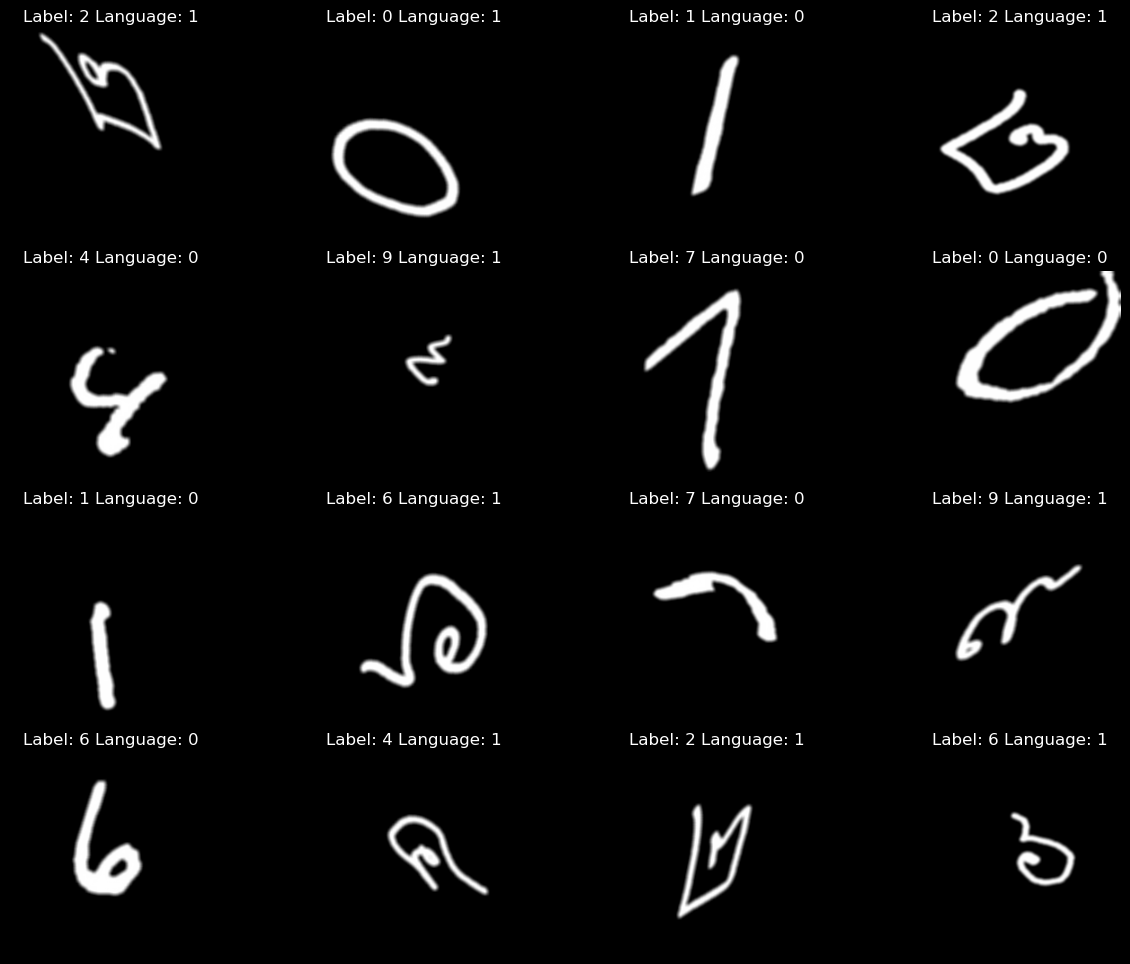

In [18]:
fig, axes = plt.subplots(4, 4, figsize=(15, 12))  # 4x4 grid for 16 images
axes = axes.flatten()

for idx, (img ,label, language, ax) in enumerate(zip(images, labels, languages, axes)):
    image = img.numpy().transpose((1, 2, 0))
    
    # Shift the image so the minimum value is 0
    shifted_image = image - image.min()
    
    # Scale the image to fit within [0, 1]
    normalized_image = shifted_image / shifted_image.max()
    
    ax.imshow(normalized_image, cmap='seismic')
    ax.axis('off')
    ax.set_title(f"Label: {label} Language: {language}")

In [19]:
class customVGG16(nn.Module):
    def __init__(self, h_dims=None, input_size=(3,224,224), trainable_idx=None):
        super(customVGG16, self).__init__()
        ### START CODE HERE ###
        
        self.vgg16 = models.vgg16(pretrained=True)
        self.vgg16.flatten = nn.Flatten()
        
        for param in self.vgg16.features.parameters():
            param.requires_grad = False

        for param in self.vgg16.classifier.parameters():
            param.requires_grad = False
            
        if trainable_idx is not None:
            for idx in trainable_idx:
                
                for param in self.vgg16.features[idx].parameters(): 
                    param.requires_grad = True
                   
        if h_dims is not None:
            classifier = []
            in_features = self._get_input_size_fc(input_size)
            for i, hdim in enumerate(h_dims):
                classifier.append(nn.Linear(in_features, hdim))
                classifier.append(nn.ReLU(inplace=True))
                classifier.append(nn.Dropout(p=0.4))
                in_features = hdim
            
            self.vgg16.classifier = nn.Sequential(*classifier)
        else:
            in_features = 1000
            
        self.classification_head = nn.Linear(in_features, 10)
        self.language_classification_head = nn.Linear(in_features, 1)
        
        ### END CODE HERE ###
        
    def _get_input_size_fc(self, input_shape):
        with torch.no_grad():
            ### START CODE HERE ###
            
            dummy_input = torch.zeros(1, *input_shape)
            x = self.vgg16.features(dummy_input)
            x = self.vgg16.flatten(x)
            return x.shape[-1]
        
            ### END CODE HERE ###

    def forward(self, x):
        ### START CODE HERE ###
        x = self.vgg16.features(x)
        x = self.vgg16.avgpool(x)
        x = self.vgg16.flatten(x)
        x = self.vgg16.classifier(x)
        
        class_output, lang_output = (self.classification_head(x), 
                                     self.language_classification_head(x))

        return F.log_softmax(class_output, dim=1), F.sigmoid(lang_output)

        ### END CODE HERE ###
        
dummy_input = torch.zeros(32, *(3, 224, 224))        
model = customVGG16(h_dims=None, input_size=(3,224,224), trainable_idx=None)

class_output, lang_output = model(dummy_input)
class_output.shape, lang_output.shape

/home/unix/miniconda3/envs/raytune_py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/unix/miniconda3/envs/raytune_py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/unix/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:27<00:00, 19.9MB/s] 


(torch.Size([32, 10]), torch.Size([32, 1]))

In [20]:
def train(model, device, train_loader, optimizer, epochs):

    bce_loss  = nn.BCELoss()
    for epoch in range(epochs):
        
        model.train()
        train_bar = tqdm(train_loader,desc=f'🚀Training Epoch [{epoch+1}/{epochs}]',unit='batch')
    
        for batch_idx, (data, target, language) in enumerate(train_bar):
            data, target = data.to(device), target.to(device)
            language = language.float().view(-1, 1).to(device)
            optimizer.zero_grad()
            
            class_output, lang_output = model(data)
            loss_class = F.nll_loss(class_output, target)
            loss_lang = bce_loss(lang_output, language)
            loss = 0.9 * loss_class + 0.1 * loss_lang
            
            loss.backward()
            optimizer.step()
            
            train_bar.set_postfix(loss=loss.item())
            
        model.eval()
        
        correct = 0
        language_correct = 0
        test_loss = 0
        test_lang_loss = 0
    
        with torch.no_grad():
            
            test_bar = tqdm(test_loader,desc=f'📄Testing  Epoch [{epoch+1}/{epochs}]',unit='batch')
            
            for data, target, language in test_bar:
                data, target, language = data.to(device), target.to(device), language.to(device)
                class_output, lang_output = model(data)
                
                test_loss += F.nll_loss(class_output, target, reduction='sum').item()
                pred = class_output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()
                
                test_lang_loss += bce_loss(lang_output, language.float().view(-1, 1))
                
                language_pred = lang_output.round()
                language_correct += language_pred.eq(language.view_as(language_pred)).sum().item()
                
            test_loss /= len(test_loader.dataset)
            test_lang_loss /= len(test_loader.dataset)

            print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\nAverage BCE loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
            test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset),
            test_lang_loss, language_correct, len(test_loader.dataset), 100. * language_correct / len(test_loader.dataset),))

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = customVGG16(h_dims=None, input_size=(3,224,224), trainable_idx=None).to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.0006)

epoch = 10
train(model, device, train_loader, optimizer, epoch)

🚀Training Epoch [1/1]:   0%|          | 0/154 [00:00<?, ?batch/s]/home/unix/miniconda3/envs/raytune_py3.10/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1712608839953/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:84.)
  return F.conv2d(input, weight, bias, self.stride,
📄Testing  Epoch [1/1]: 100%|██████████| 66/66 [00:24<00:00,  2.71batch/s]

Test set: Average loss: 2.2597, Accuracy: 257/1050 (24%)
Average BCE loss: 0.0311, Accuracy: 777/1050 (74%)


In [37]:
submit_transform = transforms.Compose([
    ReverseIntensity(threshold=100),
    transforms.ToTensor(),
    transforms.Grayscale(),
    transforms.Resize(224),
    transforms.Normalize((mean,), (std,)),
    transforms.Lambda(lambda x: torch.cat([x, x, x], 0)),
])

mean, std = 0.5070, 0.3033
submit_dataset = MultiLanguageHandwrittenDataset(root_dirs=[en_path, th_path], languages=[0, 1], transforms=submit_transform)
submit_loader = DataLoader(submit_dataset, batch_size=16, shuffle=False)
next(iter(submit_loader))[0].shape

torch.Size([16, 3, 224, 224])

In [38]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

all_targets = []
all_preds = []

all_language_targets = []
all_language_preds = []

model.eval()
model.to(device)

with torch.no_grad():
    submit_bar = tqdm(submit_loader,desc=f'📄 submit_dataset', unit='batch')
    
    for data, target, language in submit_bar:
        data, target, language = data.to(device), target.to(device), language.to(device)
        class_output, lang_output = model(data)
        
        pred = class_output.argmax(dim=1, keepdim=True)
        all_targets.extend(target.cpu().numpy())
        all_preds.extend(pred.cpu().numpy().flatten())
        
        language_pred = lang_output.round()
        all_language_targets.extend(language.cpu().numpy())
        all_language_preds.extend(language_pred.cpu().numpy().flatten())

all_targets = np.array(all_targets)
all_preds = np.array(all_preds)
all_language_targets = np.array(all_language_targets)
all_language_preds = np.array(all_language_preds)

📄 submit_dataset: 100%|██████████| 219/219 [01:09<00:00,  3.14batch/s]


/home/unix/miniconda3/envs/raytune_py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/unix/miniconda3/envs/raytune_py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/unix/miniconda3/envs/raytune_py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

              precision    recall  f1-score   support

           0       0.43      0.79      0.56       350
           1       0.37      0.53      0.44       350
           2       0.17      0.90      0.28       350
           3       0.38      0.07      0.12       350
           4       0.06      0.01      0.02       350
           5       0.26      0.19      0.22       350
           6       0.27      0.06      0.10       350
           7       0.00      0.00      0.00       350
           8       0.00      0.00      0.00       350
           9       0.27      0.01      0.02       350

    accuracy                           0.26      3500
   macro avg       0.22      0.26      0.18      3500
weighted avg       0.22      0.26      0.18      3500



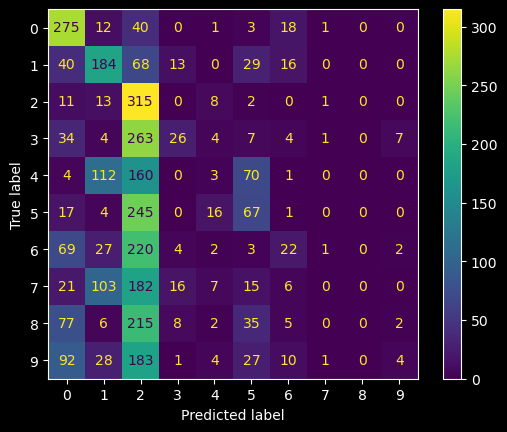

In [39]:
cm = confusion_matrix(all_targets, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

print(classification_report(all_targets, all_preds))

              precision    recall  f1-score   support

           0       0.66      1.00      0.79      1750
           1       1.00      0.48      0.65      1750

    accuracy                           0.74      3500
   macro avg       0.83      0.74      0.72      3500
weighted avg       0.83      0.74      0.72      3500



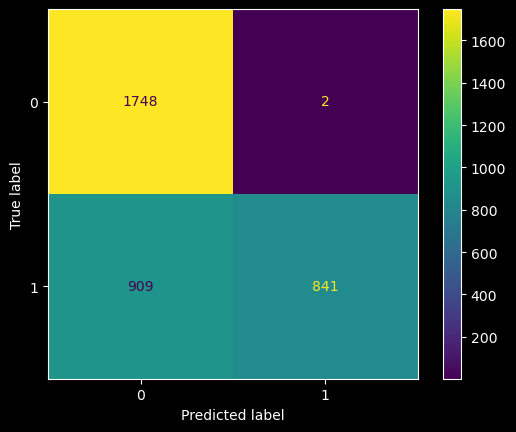

In [40]:
cm = confusion_matrix(all_language_targets, all_language_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

print(classification_report(all_language_targets, all_language_preds))